In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    auc,
    average_precision_score,
    classification_report,
    confusion_matrix,
    precision_recall_curve, 
    roc_auc_score, 
    roc_curve,
)
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, StandardScaler
from sklearn.svm import SVC


# Configs

In [2]:
project_root = "D:/Projects/Summer-2024-ECE-597-Group8"
random_state = 42
test_size = 0.8

In [3]:
df = pd.read_csv(
    os.path.join(project_root, "data", "processed", "features_labels.csv")
)

# Analysis

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25710 entries, 0 to 25709
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Homoglyphs           25710 non-null  int64
 1   Amount               25710 non-null  int64
 2   Tracking             25710 non-null  int64
 3   Postal               25710 non-null  int64
 4   Domestic_Phone       25710 non-null  int64
 5   International_Phone  25710 non-null  int64
 6   html_tags            25710 non-null  bool 
 7   js_code              25710 non-null  bool 
 8   Label                25710 non-null  int64
dtypes: bool(2), int64(7)
memory usage: 1.4 MB


In [5]:
df.describe()

,Homoglyphs,Amount,Tracking,Postal,Domestic_Phone,International_Phone,Label
count,25710.000000,25710.000000,25710.000000,25710.000000,25710.000000,25710.000000,25710.000000
mean,0.034772,0.139790,0.011941,0.002878,0.119759,0.016725,0.100000
std,1.257208,0.346776,0.108622,0.053573,0.324686,0.128242,0.300006
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,91.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


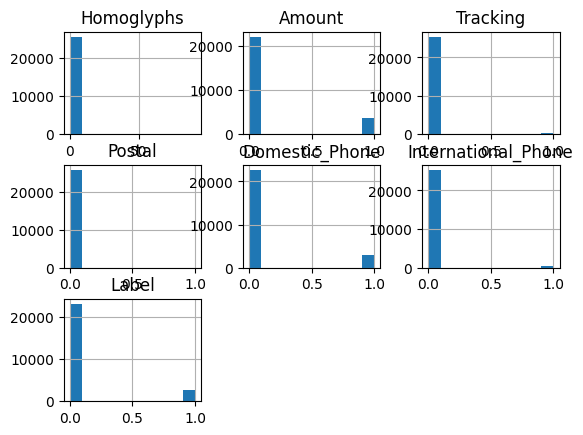

In [6]:
df.hist()
plt.show()

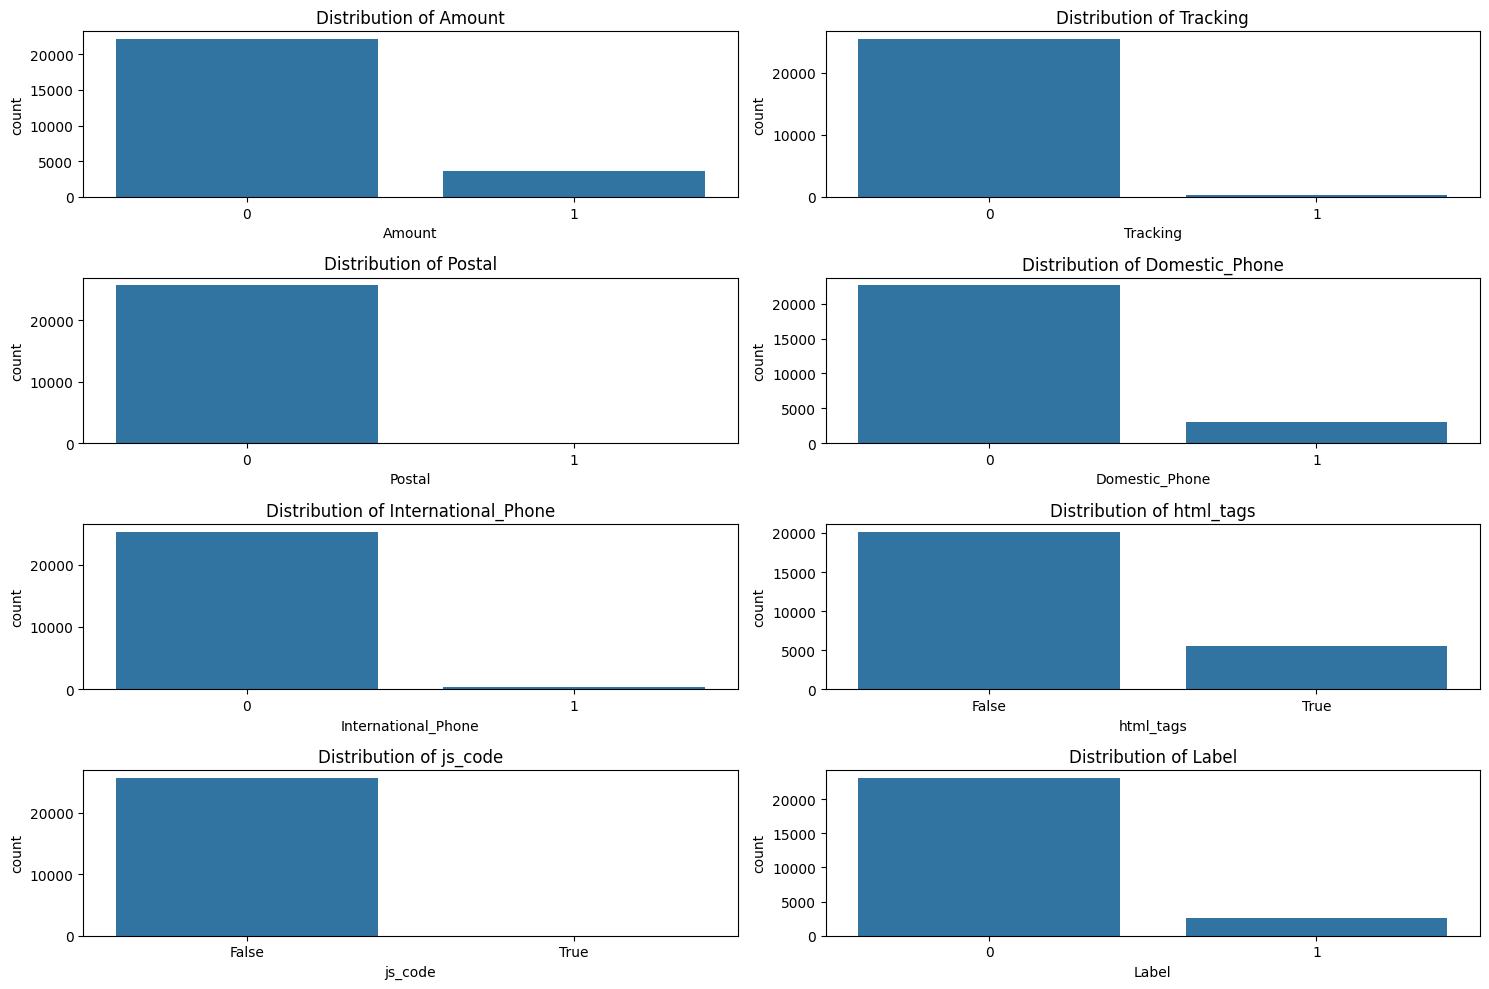

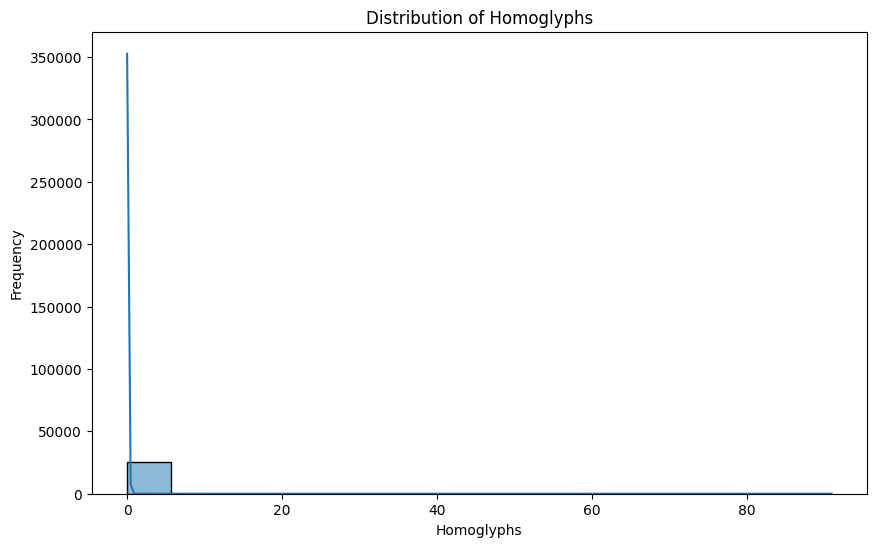

In [7]:
bool_cols = ['Amount', 'Tracking', 'Postal', 'Domestic_Phone', 'International_Phone', 'html_tags', 'js_code', 'Label']

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 10))
for col, ax in zip(bool_cols, axes.flatten()):
    sns.countplot(x=col, data=df, ax=ax)
    ax.set_title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# Histogram for 'Homoglyphs'
plt.figure(figsize=(10, 6))
sns.histplot(df['Homoglyphs'], kde=True)
plt.title('Distribution of Homoglyphs')
plt.xlabel('Homoglyphs')
plt.ylabel('Frequency')
plt.show()

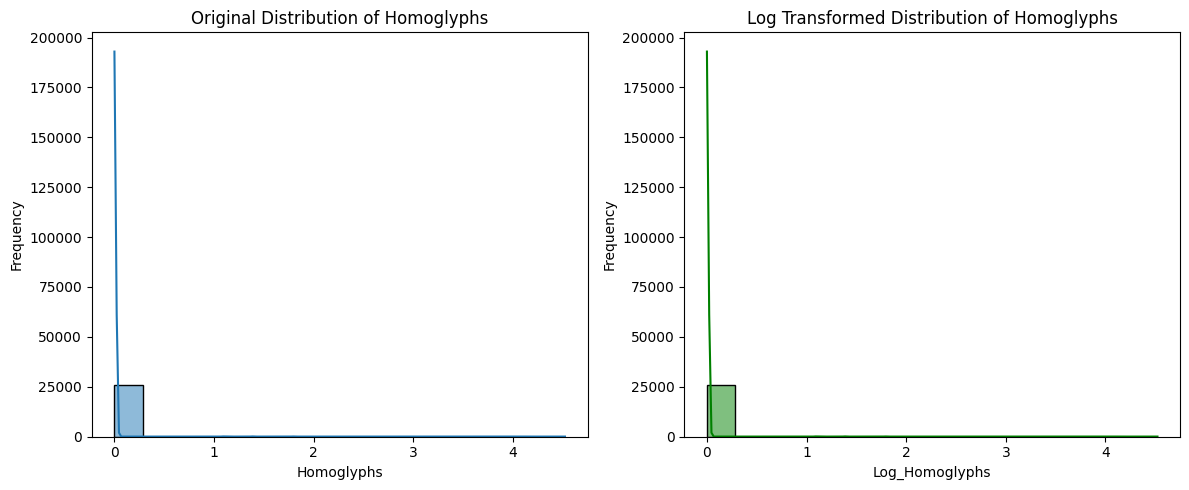

In [8]:
log_homoglyphs = np.log1p(df['Homoglyphs'])

# Histogram of the original 'Homoglyphs' feature
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(log_homoglyphs, kde=True)
plt.title('Original Distribution of Homoglyphs')
plt.xlabel('Homoglyphs')
plt.ylabel('Frequency')

# Histogram of the log-transformed 'Homoglyphs' feature
plt.subplot(1, 2, 2)
sns.histplot(log_homoglyphs, kde=True, color='green')
plt.title('Log Transformed Distribution of Homoglyphs')
plt.xlabel('Log_Homoglyphs')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Experiments

In [9]:
def evaluate_model(model, X, y, cv=5):
    """
    Evaluates the performance of a binary classifier using cross-validation.

    Args:
    model (estimator): The machine learning model to evaluate.
    X (DataFrame or array-like): Feature data used for training the model.
    y (array-like): True labels.
    cv (int): Number of cross-validation folds.

    Returns:
    None
    """
    # Get decision function scores via cross-validation
    y_scores = cross_val_predict(model, X, y, cv=cv, method='decision_function')

    # Convert decision scores to binary predictions using 0 as a threshold
    y_pred = (y_scores > 0).astype(int)

    # Print classification report
    print("Classification Report:")
    print(classification_report(y, y_pred))

    # Print confusion matrix
    print("Confusion Matrix:")
    print(confusion_matrix(y, y_pred))

    # Calculate and print accuracy
    accuracy = accuracy_score(y, y_pred)
    print(f"Accuracy: {accuracy:.2f}")

    # Calculate ROC-AUC and Precision-Recall
    roc_auc = roc_auc_score(y, y_scores)
    average_precision = average_precision_score(y, y_scores)

    # Print ROC-AUC and Average Precision-Recall scores
    print(f"ROC-AUC Score: {roc_auc:.2f}")
    print(f"Average Precision-Recall Score: {average_precision:.2f}")

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y, y_scores)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Random predictions curve
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Plot Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y, y_scores)
    plt.figure()
    plt.plot(recall, precision, label=f'Precision-Recall curve (area = {average_precision:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curve')
    plt.legend(loc="upper right")
    plt.show()

In [10]:
X = df.drop(columns=["Label"])
y = df["Label"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=random_state
)

In [11]:
def bool_to_int(x):
    return x.astype(int)


def log_transform(x):
    return np.log1p(x)


homoglyphs_pipeline = make_pipeline(FunctionTransformer(log_transform))
homoglyphs_pipeline_MinMax = make_pipeline(
    FunctionTransformer(log_transform), MinMaxScaler()
)
homoglyphs_pipeline_standardScaler = make_pipeline(
    FunctionTransformer(log_transform), StandardScaler()
)

features_preprocessor = ColumnTransformer(
    transformers=[
        ("homoglyphs", homoglyphs_pipeline, ["Homoglyphs"]),
        ("bools", FunctionTransformer(bool_to_int), ["html_tags", "js_code"]),
    ],
    remainder="passthrough",
)

Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     23139
           1       0.86      0.03      0.06      2571

    accuracy                           0.90     25710
   macro avg       0.88      0.51      0.50     25710
weighted avg       0.90      0.90      0.86     25710

Confusion Matrix:
[[23127    12]
 [ 2495    76]]
Accuracy: 0.90
ROC-AUC Score: 0.51
Average Precision-Recall Score: 0.18


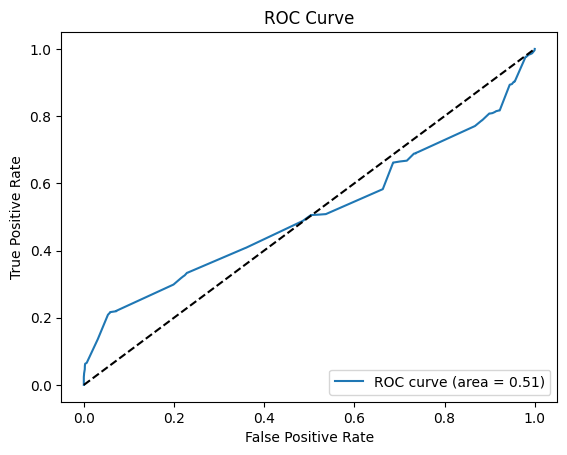

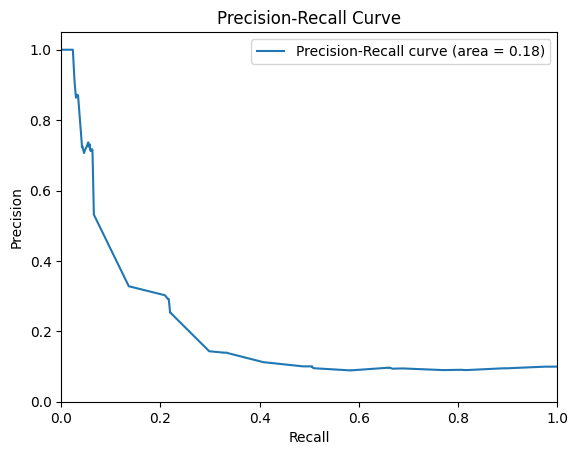

In [12]:
model = make_pipeline(
    features_preprocessor,
    PCA(n_components=0.95),
    SVC(
        C=1.0, kernel="rbf", gamma="scale", probability=True, random_state=random_state
    ),
)

model.fit(X_train, y_train)
evaluate_model(model, X, y)